A given match, with isobaric spaces, could match a number of other peptide sequences as well. Here we will quantify this effect.

In [9]:
import re
import pandas as pd

from itertools import chain
from psm_utils import Peptidoform
from denovo_utils.analysis.missing_fragmentations import get_ambiguous_tags
from pyteomics import mass as ptmass
from matplotlib import pyplot as plt

import seaborn as sns
import numpy as np

In [2]:
db = ptmass.Unimod()
aa_comp = ptmass.std_aa_comp
aa_comp["ox"] = db.by_id(35)["composition"]
aa_comp["c"] = db.by_id(4)["composition"]

class PeptideEvidence:
    def __init__(self, aa_comp, mod_dict={"UNIMOD:4": "c", "UNIMOD:35": "ox"}, peptide_evidence=None, proforma=None, evidence_bool=None):
        if peptide_evidence is not None:
            self.peptidoform = peptide_evidence.peptidoform
            self.evidence = peptide_evidence.evidence
            self.ambiguous_tag_indices = peptide_evidence.ambiguous_tag_indices
            self.set_mod_to_token(aa_comp=aa_comp, mod_dict=mod_dict)
        else:
            self.peptidoform = Peptidoform(proforma)
            self.evidence = evidence_bool
            self.ambiguous_tag_indices = get_ambiguous_tags(self.peptidoform, self.evidence)
            self.set_mod_to_token(aa_comp=aa_comp, mod_dict=mod_dict)
        
    def set_mod_to_token(self, aa_comp, mod_dict):
        self.mod_dict = mod_dict
        for i in mod_dict.values():
            try:
                _=aa_comp[i]
            except:
                Exception(f"{i} not in aa_comp!")
        self.aa_comp = aa_comp
    
    def parse_tag(self, tag_peptide):
        tag_peptide_reconstr = ""
        tag_mass = ""
        for aa, mods in tag_peptide:
            tag_peptide_reconstr+=aa
            if mods:
                for mod in mods:
                    mod = str(mod)
                    tag_peptide_reconstr+="["+mod+"]"
                    tag_mass+=self.mod_dict[mod]
            tag_mass += aa

        return (tag_peptide_reconstr, ptmass.calculate_mass(tag_mass, aa_comp=self.aa_comp))    

    def return_tags(self):
        peptidoform_list = list(self.peptidoform)
        tags = []
        for tag in self.ambiguous_tag_indices:
            tag_peptide = peptidoform_list[tag[0]:tag[1]]
            tags.append(self.parse_tag(tag_peptide))
        return tags

    def __repr__(self):

        peptide_repr = ""
        first_tags = [i[0] for i in self.ambiguous_tag_indices]
        end_tags = [i[1]-1 for i in self.ambiguous_tag_indices]

        for i, aa in enumerate(self.peptidoform.parsed_sequence):
            mod = ""
            if aa[1]:
                mod = "[" + str(aa[1][0]) + "]"
            aa_repr = aa[0]+mod

            if i in first_tags:
                peptide_repr += "<"
            peptide_repr += aa_repr
            if i in end_tags:
                peptide_repr += ">"
        peptide_repr += "/"+str(self.peptidoform.precursor_charge)
        return peptide_repr

In [3]:
peptide_evidence = pd.read_pickle("/home/samva/Doctorate/DeNovo_Benchmark/notebooks/scrap_notes/peptide_evidence_S03.pkl")

In [4]:
mod_regex = r'\[(.*?)\]'
peptide_evidence["peptide_evidence"] = peptide_evidence.peptide_evidence.apply(lambda x: PeptideEvidence(aa_comp=aa_comp, peptide_evidence=x))
peptide_evidence["proforma"] = peptide_evidence.peptide_evidence.apply(lambda x: x.peptidoform.proforma)
peptide_evidence["modified"] = peptide_evidence.proforma.apply(lambda x: "UNIMOD" in x)
peptide_evidence["modifications"] = peptide_evidence.apply(lambda x: set(re.findall(mod_regex, x["proforma"])) if x["modified"] else set(), axis=1)
peptide_evidence["precursor_charge"] = peptide_evidence.peptide_evidence.apply(lambda x: x.peptidoform.precursor_charge)
peptide_evidence["tags"] = peptide_evidence.peptide_evidence.apply(lambda x: x.return_tags())

In [5]:
peptide_evidence[peptide_evidence.modified].head()

,peptide_evidence,proforma,modified,modifications,precursor_charge,tags
1,M[UNIMOD:35]GTTNGW<SC[UNIMOD:4]>IFAR/2,M[UNIMOD:35]GTTNGWSC[UNIMOD:4]IFAR/2,True,"{UNIMOD:35, UNIMOD:4}",2,"[(SC[UNIMOD:4], 265.07324159325003)]"
6,<AGFGD>ELTSGC[UNIMOD:4]VNTS<GL>LK/2,AGFGDELTSGC[UNIMOD:4]VNTSGLLK/2,True,{UNIMOD:4},2,"[(AGFGD, 465.18596284637), (GL, 188.1160923814)]"
9,<IV><VNSSTG>LP<VE>A<SEF>GIC[UNIMOD:4]GDMN<NK>/3,IVVNSSTGLPVEASEFGIC[UNIMOD:4]GDMNNK/3,True,{UNIMOD:4},3,"[(IV, 230.16304257381998), (VNSSTG, 563.255105..."
11,<ASYG>C[UNIMOD:4]EGFLGNYE<GE>VR/2,ASYGC[UNIMOD:4]EGFLGNYEGEVR/2,True,{UNIMOD:4},2,"[(ASYG, 396.1644991258), (GE, 204.07462149224)]"
17,<LDQ>TGVGQLVQM[UNIMOD:35]AAEK/2,LDQTGVGQLVQM[UNIMOD:35]AAEK/2,True,{UNIMOD:35},2,"[(LDQ, 374.18014918994)]"


In [6]:
isobaric_tags = [i[0] for i in list(chain(*peptide_evidence["tags"].tolist()))]
isobaric_masses = [i[1] for i in list(chain(*peptide_evidence["tags"].tolist()))]

<Axes: xlabel='mass', ylabel='Count'>

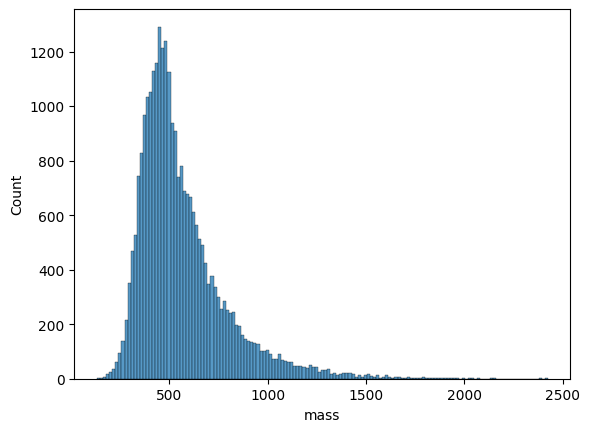

In [7]:
sns.histplot(
    pd.DataFrame(
        {
            "tag": isobaric_tags,
            "mass": isobaric_masses
        }
    ).drop_duplicates()["mass"]
)

In [8]:
aas = [i for i in "ADEFGHLKMNPQRSTVWY"] + ["cC", "oxM"]

In [10]:
def get_combinations(combination_df, mass, tolerance):
    masses = combination_df[
        (combination_df.mass < (mass+tolerance)) &
        (combination_df.mass > (mass-tolerance))
    ]
    return list(chain(*masses.aa.tolist()))

def get_unique_aa_compositions(list_of_aa):
    unique_composition = set()
    for aa in list_of_aa:
        sorted_composition = tuple(sorted(aa))
        unique_composition.add(sorted_composition)
    return len(unique_composition)

def get_alternatives(tags, combination_df, tolerance=.02):
    n_alternatives = 1
    for _, mass in tags:
        if len(Peptidoform(_+"/2")) > 5:
            return np.nan
        n_alternatives *= len(
            get_combinations(
                combination_df=combination_df,
                mass=mass,
                tolerance=tolerance
                )
        )
    return n_alternatives

In [11]:
from itertools import permutations
from tqdm import tqdm
import numpy as np
tqdm.pandas()

aa_2_comp = list(["".join(x) for x in permutations(aas, 2)])
aa_3_comp = list(["".join(x) for x in permutations(aas, 3)])
aa_4_comp = list(["".join(x) for x in permutations(aas, 4)])
aa_5_comp = list(["".join(x) for x in permutations(aas, 5)])

aa_comps = aa_2_comp+aa_3_comp+aa_4_comp+aa_5_comp

aa_df = pd.DataFrame(aa_comps).rename(columns={0: "aa"})
aa_df["mass"] = aa_df.progress_apply(lambda x: np.round(
        ptmass.calculate_mass(x["aa"], aa_comp=aa_comp),
        decimals=6
    ), axis=1)

100%|██████████| 1983980/1983980 [00:40<00:00, 49208.71it/s]


In [12]:
mass_to_aa_combinations = aa_df.groupby("mass").aa.apply(list).reset_index().sort_values("mass")

In [13]:
mass_to_aa_combinations["combinations"] = mass_to_aa_combinations.aa.apply(len)
mass_to_aa_combinations["unique_compositions"] = mass_to_aa_combinations.aa.apply(get_unique_aa_compositions)

<Axes: xlabel='mass', ylabel='unique_compositions'>

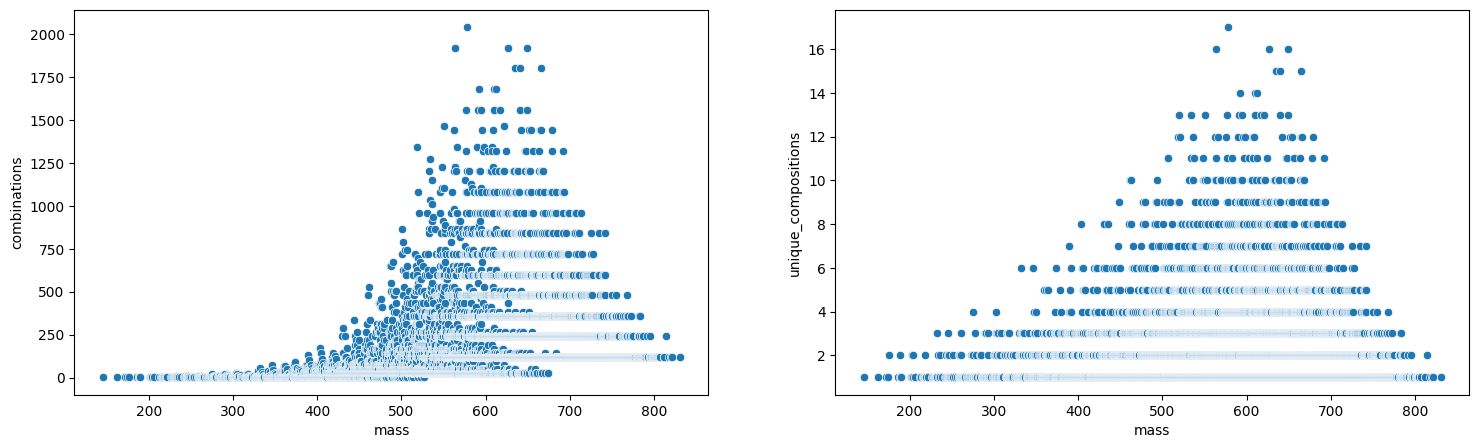

In [14]:
fig, ax = plt.subplots(1,2,figsize=(18,5))
sns.scatterplot(
    mass_to_aa_combinations,
    x="mass",
    y="combinations",
    ax=ax[0]
)
sns.scatterplot(
    mass_to_aa_combinations,
    x="mass",
    y="unique_compositions",
    ax=ax[1]
)

In [15]:
mass_to_aa_combinations.unique_compositions.value_counts()

unique_compositions
1     4709
2     1841
3     1194
4      616
5      385
6      266
7      149
8      106
9       69
10      45
11      21
12      17
13      12
16       4
14       3
15       3
17       1
Name: count, dtype: int64

In [16]:
mass_to_aa_combinations[mass_to_aa_combinations.unique_compositions==17]

,mass,aa,combinations,unique_compositions
3738,578.237012,"[ADLNoxM, ADLTcC, ADLcCT, ADLoxMN, ADNLoxM, AD...",2040,17


In [17]:
def get_alternative_compositions(tags, combination_df, tolerance=.02):
    n_alternatives = 1
    for _, mass in tags:
        n_alternatives *= combination_df.loc[
            (combination_df.mass < (mass+tolerance)) &
            (combination_df.mass > (mass-tolerance)),
            "unique_compositions"
        ].sum()
    return n_alternatives

peptide_evidence["alternative_aa_compositions"] = peptide_evidence.tags.progress_apply(
    lambda x: get_alternative_compositions(x, combination_df=mass_to_aa_combinations)
)

100%|██████████| 76866/76866 [00:31<00:00, 2431.95it/s]


/home/samva/miniconda3/envs/denovo_analysis_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='alternative_aa_compositions', ylabel='Density'>

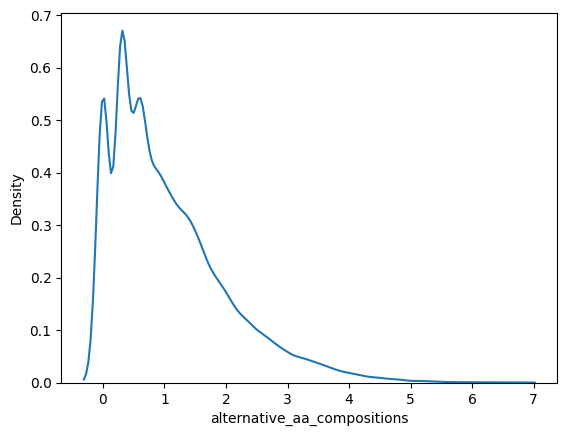

In [27]:
sns.kdeplot(np.log10(peptide_evidence["alternative_aa_compositions"].sort_values()))

In [22]:
peptide_evidence.loc[25594].peptide_evidence

<HAC[UNIMOD:4]GAA><VE><C[UNIMOD:4]V>I<SD><TC[UNIMOD:4]IA>G<MAEA>AA<C[UNIMOD:4]EEK>/3

In [23]:
peptide_evidence.loc[25594].proforma

'HAC[UNIMOD:4]GAAVEC[UNIMOD:4]VISDTC[UNIMOD:4]IAGMAEAAAC[UNIMOD:4]EEK/3'

In [126]:
peptide_evidence["n_alternatives"] = peptide_evidence.tags.progress_apply(
    lambda x: get_alternatives(x, combination_df=mass_to_aa_combinations)
)

100%|██████████| 76866/76866 [00:31<00:00, 2465.86it/s]


/home/samva/miniconda3/envs/denovo_analysis_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='n_alternatives', ylabel='Count'>

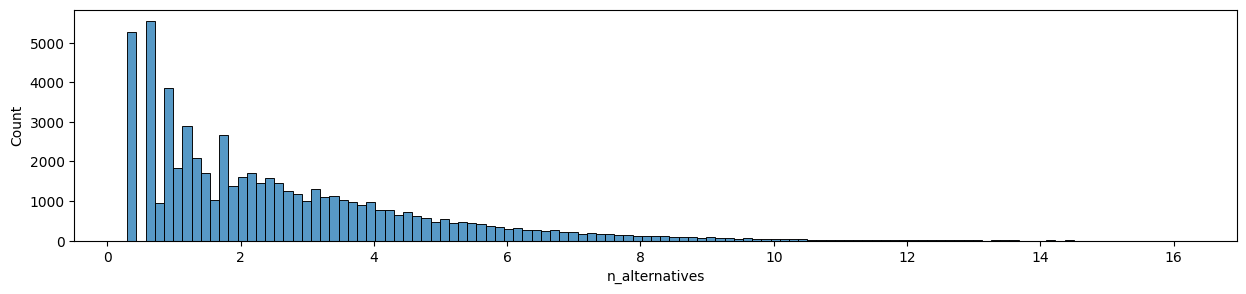

In [133]:
plt.figure(figsize=(15,3))
sns.histplot(np.log10(peptide_evidence.n_alternatives))

In [127]:
peptide_evidence.sort_values("n_alternatives", ascending=False)

,peptide_evidence,proforma,modified,modifications,precursor_charge,tags,n_alternatives
46137,<FEAT><KA>E<TAQA><APEQA><PQ><PQQQQ>H<SQ><PQQR>/3,FEATKAETAQAAPEQAPQPQQQQHSQPQQR/3,False,{},3,"[(FEAT, 466.20636393778), (KA, 217.14264148241...",1.425686e+16
55561,<STVAQ>V<YQQI><FDDL><NL><AQ><DYL><TNYVR>/2,STVAQVYQQIFDDLNLAQDYLTNYVR/2,False,{},2,"[(STVAQ, 504.25437675936), (YQQI, 550.27511220...",3.718410e+15
43897,<SFWD><NA><AYH>T<GNMEA>YFL<TNK><PEYL>E<YSK>/4,SFWDNAAYHTGNMEAYFLTNKPEYLEYSK/4,False,{},4,"[(SFWD, 553.21726297465), (NA, 203.09060590955...",1.658675e+15
67843,<VE><LQSD><KGV><ELV><KD><WQV><YTI><PVD><YSFAR>/3,VELQSDKGVELVKDWQVYTIPVDYSFAR/3,False,{},3,"[(VE, 246.12157168466), (LQSD, 461.21217759421...",1.289081e+15
52324,<VSSNN>SQ<MN>L<ADGKE><PWSNI><YQ><GIEK>/3,VSSNNSQMNLADGKEPWSNIYQGIEK/3,False,{},3,"[(VSSNN, 519.22889028751), (MN, 263.0939770378...",9.092823e+14
...,...,...,...,...,...,...,...
76857,<SA>TA<PHRENLAS>VR/3,SATAPHRENLASVR/3,False,{},3,"[(SA, 176.07970687268), (PHRENLAS, 922.4620781...",NaN
76858,<VN>I<ID>TP<GHV>D<FTVEVE>R/3,VNIIDTPGHVDFTVEVER/3,False,{},3,"[(VN, 231.12190603783), (ID, 246.12157168466),...",NaN
76861,<SPTE>VYK<PSPFTNM[UNIMOD:35]GR>/2,SPTEVYKPSPFTNM[UNIMOD:35]GR/2,True,{UNIMOD:35},2,"[(SPTE, 432.1856284932), (PSPFTNM[UNIMOD:35]GR...",NaN
76862,<NGI>L<NIDVLSFE>R/2,NGILNIDVLSFER/2,False,{},2,"[(NGI, 302.15901982254), (NIDVLSFE, 935.460012...",NaN


In [120]:
get_combinations(
    combination_df=mass_to_aa_combinations,
    mass=189.07495584541,
    tolerance=.02
)

['GN', 'NG']

In [11]:
pe_example = peptide_evidence.loc[0, "peptide_evidence"]

In [31]:
str(list(peptide_evidence[peptide_evidence["modified"]]["peptide_evidence"].iloc[0].peptidoform)[8][1][0])

'UNIMOD:4'

In [24]:
str(list(peptide_evidence[peptide_evidence["modified"]]["peptide_evidence"].iloc[0].peptidoform)[0][1][0])

'UNIMOD:35'

In [55]:
peptide_evidence[peptide_evidence.modified].modifications.value_counts()

modifications
{UNIMOD:4}               11481
{UNIMOD:35}               8692
{UNIMOD:35, UNIMOD:4}     1905
Name: count, dtype: int64

In [66]:
str(list(peptide_evidence[peptide_evidence.modified].iloc[0]["peptide_evidence"].peptidoform)[0][1][0])

'UNIMOD:35'

In [28]:
from denovo_utils.parsers.constants import MODIFICATION_MAPPING

In [36]:
from itertools import chain
mods_mapping = list(set(chain(*[i.values() for i in MODIFICATION_MAPPING.values()])))
modifications = [
    "[UNIMOD:1]",
    "[UNIMOD:4]",
    "[UNIMOD:5]",
    "[UNIMOD:7]",
    "[UNIMOD:21]",
    "[UNIMOD:23]",
    "[UNIMOD:35]",
    "[UNIMOD:385]"
]